# Can we leverage machine learning to predict Alzheimers?

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import pandas_profiling as pdp

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [2]:
ocs = pd.read_csv('C:/Users/admin/Desktop/oasis_cross-sectional.csv')
ol = pd.read_csv('C:/Users/admin/Desktop/oasis_longitudinal.csv')

### Generating Pandas Profiling report to understand the data

In [3]:
#Profiling Report - ocs
report=pdp.ProfileReport(ocs,title="Cross-sectional report")
report.to_notebook_iframe()

#Profiling Report - ol
report=pdp.ProfileReport(ol,title="Longitudinal report")
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Preprocessing

In [4]:
#Data Preprocessing - ocs:
ocs = ocs.dropna(subset=['CDR'])
ocs = ocs.drop(['Hand','Delay'],axis=1)
ocs.fillna(ocs['SES'].median(),inplace=True) #Median Imputation
ocs['Demented'] = np.where(ocs['CDR']==0, 0, 1) #One-Hot Encoding

In [5]:
#Data Preprocessing - ol:
ol = ol.drop(['Hand'],axis=1)
ol.fillna(ol['SES'].median(),inplace=True) #median Imputation
ol.fillna(ol['MMSE'].median(),inplace=True) #median Imputation
ol = ol.replace({"Group": {'Demented':1, 'Nondemented':0, 'Converted':2}}) #Label encoding
ol['Demented'] = np.where(ol['CDR']==0, 0, 1) #One-Hot Encoding

#Binning education years to eduaction levels to mirror ocs
bins=np.array([6,10,14,18,21,23])
labels = [1.0,2.0,3.0,4.0,5.0]
ol['Educ'] = pd.cut(ol['EDUC'], bins=bins, labels=labels, include_lowest=True) 
ol = ol.drop(['EDUC'],axis=1)

#Correcting a data anamoly found via initial data viz (affects 2 columns)
ol.loc[(ol['Group']==0) & (ol['Demented']==1), 'Group'] = 2

## Data Visualisation

### Understanding the distribution of the dataset

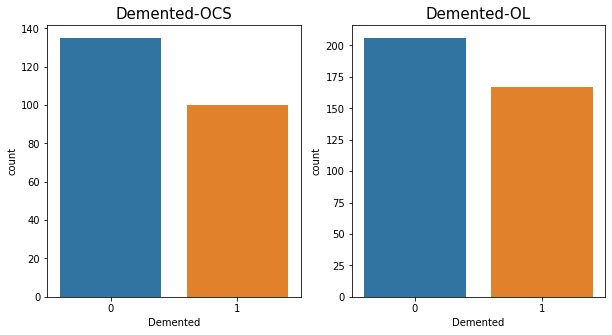

In [6]:
f, ax = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x='Demented', data=ocs, ax=ax[0])
ax[0].set_title('Demented-OCS',fontsize=15)

sns.countplot(x='Demented', data=ol, ax=ax[1])
ax[1].set_title('Demented-OL',fontsize=15)

plt.show()

### Understanding how previously assigned groups correlate to current CDR

<AxesSubplot:xlabel='Group', ylabel='count'>

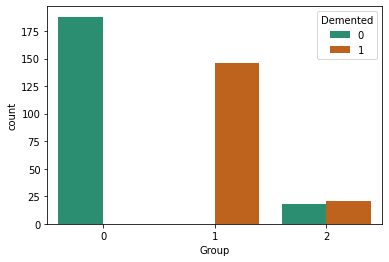

In [7]:
sns.countplot(x ='Group', hue ='Demented', data=ol, palette='Dark2')

### Dementia and Gender

<AxesSubplot:xlabel='M/F', ylabel='Count'>

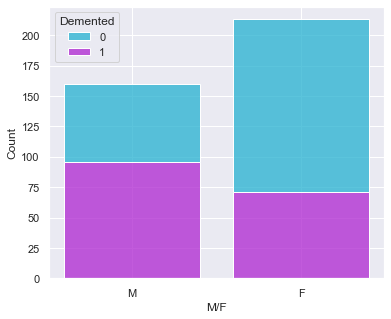

In [8]:
sns.set(rc={'figure.figsize':(6,5)})
sns.histplot(ol, x='M/F', hue='Demented', multiple='stack', palette=['#24b1d1', '#ae24d1'],shrink=0.8)

### Dementia and Education levels

<AxesSubplot:xlabel='Educ', ylabel='Count'>

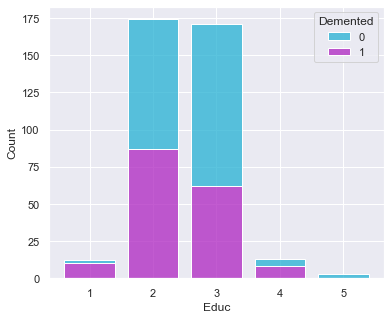

In [9]:
sns.set(rc={'figure.figsize':(6,5)})
sns.histplot(ol, x='Educ', hue='Demented', multiple='stack', palette=['#24b1d4', '#ae24c1'],shrink=0.8)

### Comparison of MMSE scores of Demented and NonDemented patients

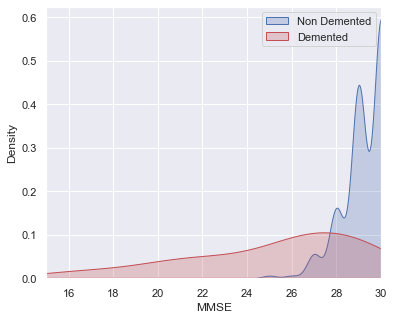

In [10]:
sns.kdeplot(ol.loc[(ol['Demented']==0),'MMSE'],color='b', shade=True)
sns.kdeplot(ol.loc[(ol['Demented']==1),'MMSE'],color='r', shade=True)
plt.xlim([15,30])
plt.legend(labels=['Non Demented','Demented'])

### Comparison of Age in the cross-sectional Dataset

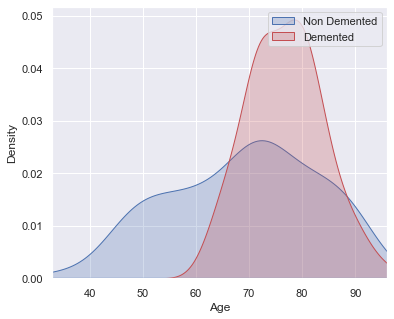

In [11]:
sns.kdeplot(ocs.loc[(ocs['Demented']==0),'Age'],color='b', shade=True)
sns.kdeplot(ocs.loc[(ocs['Demented']==1),'Age'],color='r', shade=True)
plt.xlim([33,96])
plt.legend(labels=['Non Demented','Demented'])

### Correlation map of cross-sectional dataset

<AxesSubplot:>

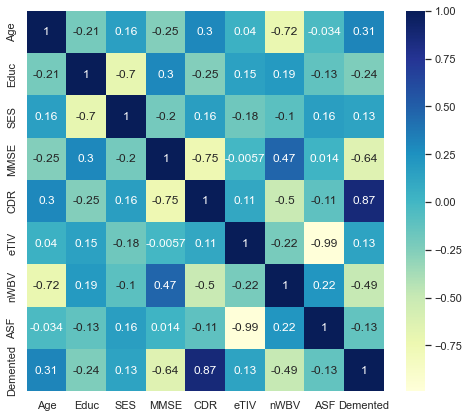

In [12]:
sns.set(rc={'figure.figsize':(8,7)})
sns.heatmap(ocs.corr(), cmap="YlGnBu", annot=True)

### Correlation map of longitudinal dataset

<AxesSubplot:>

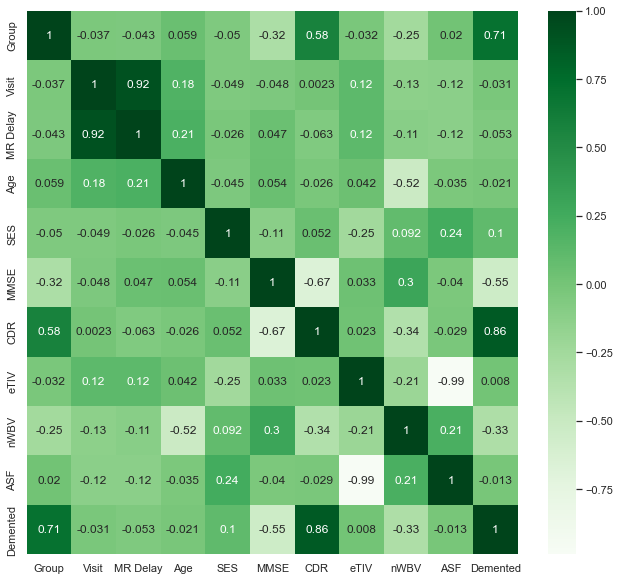

In [13]:
sns.set(rc={'figure.figsize':(11,10)})
sns.heatmap(ol.corr(), cmap="Greens", annot=True)

## Confusion matrix illustration

In [14]:
def show_confusion_matrix(C,class_labels=['0','1']):    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

## Building ML Models for OL

### Performing splitting and feauture scaling

In [15]:
ol = ol.replace({"M/F": {'M':1, 'F':0}})
Y = ol['Demented'] # Target 
X = ol[['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Inputs

#80:20 Train-Test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

### SVM model

Best accuracy on cross validation set is: 0.8456497175141242
Best parameter for c is:  100
Best parameter for gamma is:  0.001
Best parameter for kernel is:  linear
Test accuracy with the best parameters is 0.7733333333333333
Test recall with the best parameters is 0.7222222222222222
Test auc with the best parameter is 0.7713675213675213


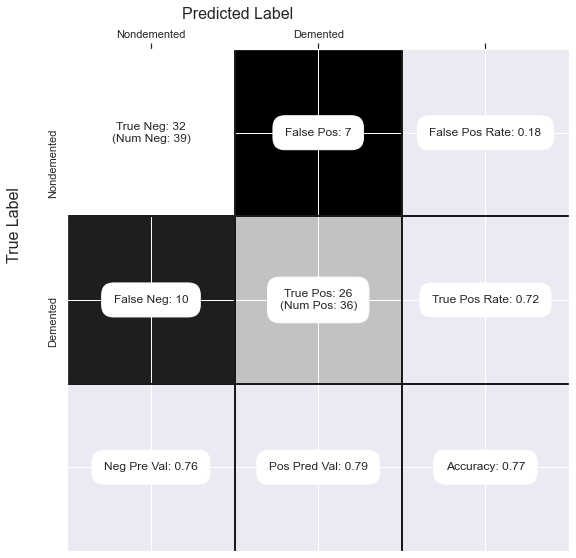

In [16]:
best_score = 0
kfolds = 5 
acc_ol = []

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
                
# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test auc with the best parameter is", test_auc)

m = 'SVM_OL'
acc_ol.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

### Random Forest model

Best accuracy on validation set is: 0.8559322033898304
Best parameters of M, d, m are:  14 1 6
Test accuracy with the best parameters is 0.8533333333333334
Test recall with the best parameters is: 0.7777777777777778
Test AUC with the best parameters is: 0.8504273504273504


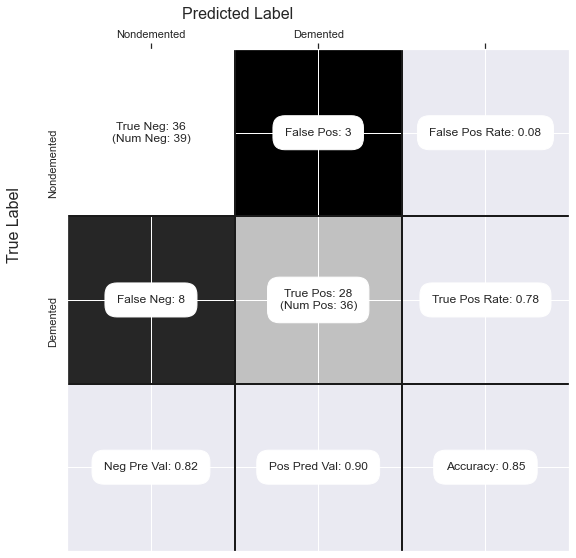

In [17]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest_OL'
acc_ol.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

In [18]:
#Looking into feature importance
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

array([['M/F', '0.06958558652398748'],
       ['Age', '0.080611484947681'],
       ['Educ', '0.007831742451427993'],
       ['SES', '0.04045387576598841'],
       ['MMSE', '0.5229307510935142'],
       ['eTIV', '0.06111762990820105'],
       ['nWBV', '0.14040800681262433'],
       ['ASF', '0.07706092249657569']], dtype='<U32')

### AdaBoost model

Best accuracy on validation set is: 0.8289830508474576
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.8533333333333334
Test recall with the best parameters is: 0.6111111111111112
Test AUC with the best parameters is: 0.7670940170940171


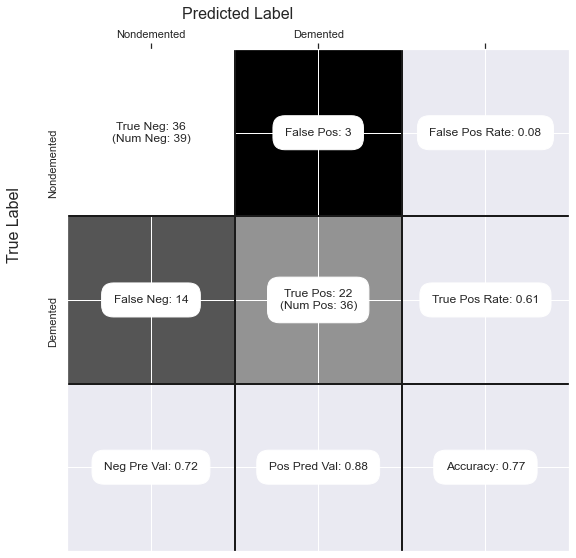

In [19]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost_OL'
acc_ol.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

## Building ML models for OCS

### Performing splitting and feature scaling

In [21]:
ocs = ocs.replace({"M/F": {'M':1, 'F':0}})
Y = ocs['Demented'] #Target
X = ocs[['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] #Input

X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

### SVM model

Best accuracy on cross validation set is: 0.8512091038406828
Best parameter for c is:  10
Best parameter for gamma is:  1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.723404255319149
Test recall with the best parameters is 0.6818181818181818
Test auc with the best parameter is 0.7209090909090908


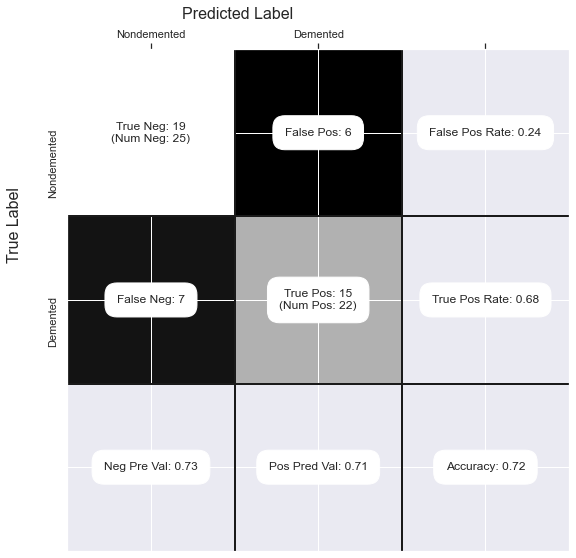

In [22]:
best_score = 0
kfolds = 5 
acc_ocs = []

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
                
# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test auc with the best parameter is", test_auc)

m = 'SVM_OCS'
acc_ocs.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

### Random Forest model

Best accuracy on validation set is: 0.856330014224751
Best parameters of M, d, m are:  6 7 3
Test accuracy with the best parameters is 0.8085106382978723
Test recall with the best parameters is: 0.8181818181818182
Test AUC with the best parameters is: 0.8090909090909092


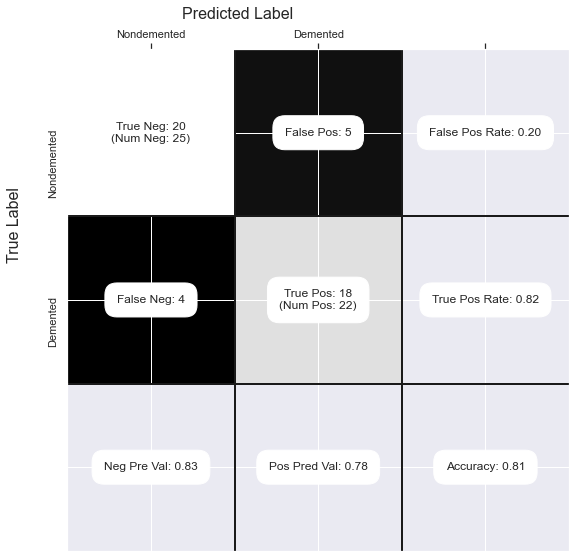

In [23]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest_OCS'
acc_ocs.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

In [24]:
#Looking into feature importance
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

array([['M/F', '0.01658945570911986'],
       ['Age', '0.15328706589429247'],
       ['Educ', '0.020792523876249802'],
       ['SES', '0.028293536052541562'],
       ['MMSE', '0.516680407457405'],
       ['eTIV', '0.05385165575404903'],
       ['nWBV', '0.1483482560882572'],
       ['ASF', '0.062157099168085005']], dtype='<U32')

### AdaBoost Model

Best accuracy on validation set is: 0.8192034139402562
Best parameter of M is:  8
best parameter of LR is:  0.1
Test accuracy with the best parameter is 0.8085106382978723
Test recall with the best parameters is: 0.6818181818181818
Test AUC with the best parameters is: 0.7609090909090909


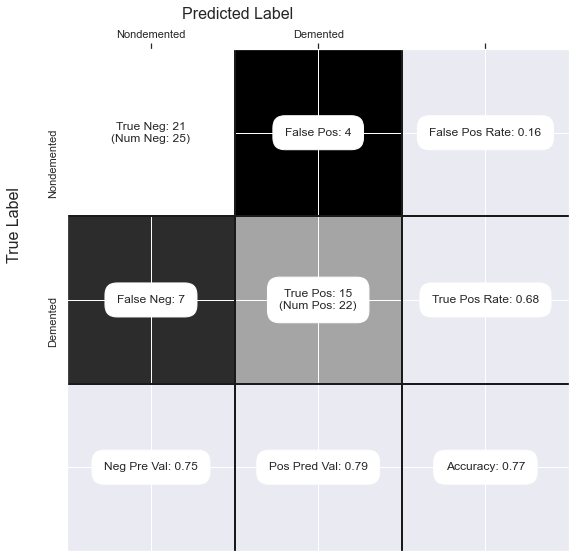

In [25]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost_OCS'
acc_ocs.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

show_confusion_matrix(confusion_matrix(Y_test, PredictedOutput), ["Nondemented","Demented"])

## Model comparison and conclusion

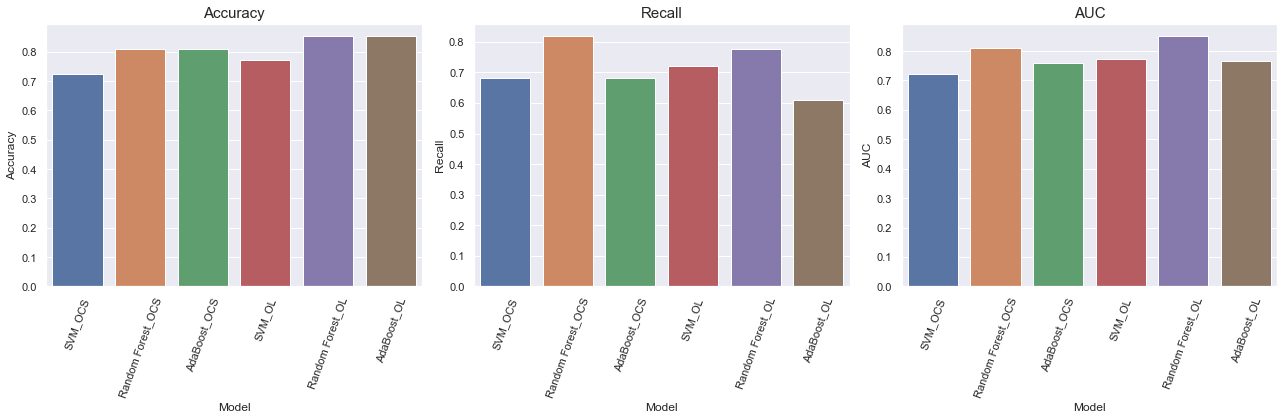

In [31]:
result_ol = pd.DataFrame(acc_ol, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result_ocs = pd.DataFrame(acc_ocs, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result = pd.concat([result_ocs,result_ol])

#Visualisation of the above data
f, ax = plt.subplots(1, 3, figsize=(18,6))
sns.barplot(x=result['Model'], y=result['Accuracy'], ax=ax[0], ci=None)
ax[0].set_title('Accuracy',fontsize=15)
ax[0].tick_params(axis="x",rotation=70)
sns.barplot(x=result['Model'], y=result['Recall'], ax=ax[1], ci=None)
ax[1].set_title('Recall',fontsize=15)
ax[1].tick_params(axis="x",rotation=70)
sns.barplot(x=result['Model'], y=result['AUC'], ax=ax[2], ci=None)
ax[2].set_title('AUC',fontsize=15)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()